In [18]:
import numpy as np
from tqdm import tqdm

from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d


import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# Optimal Growth Model

In [2]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

In [37]:
def f(i, r, p):
    """
    Return production given investment amount, expected returns, and portfolio.
    """
    return sum(i*r*p)


def u(x, rho=1):
    """
    CRRA utility function.
    """
    return np.log(x)
    
    
#     if rho==1:
#         return np.log(x)
#     else:
#         return (x**(1-rho))/(1-rho)

In [38]:
class OptimalGrowthModel:

    def __init__(self,
                 u,            # utility function
                 f,            # production function
                 r,            # expected returns of projects
                 p,            # portfolio
                 β=0.96,       # discount factor
                 grid_max=4,
                 grid_size=120):

        self.u, self.f, self.r, self.p, self.β = u, f, r, p, β

        # Set up grid
        self.grid = np.linspace(1e-4, grid_max, grid_size)


    def state_action_value(self, c, y, v_array):
        """
        Right hand side of the Bellman equation.
        """
        u, f, β, r, p = self.u, self.f, self.β, self.r, self.p
        v = interp1d(self.grid, v_array)
        return u(c) + β*v(f(y - c, r, p))
    

def T(v, og):
    """
    The Bellman operator.  Updates the guess of the value function
    and also computes a v-greedy policy.

      * og is an instance of OptimalGrowthModel
      * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for i in range(len(grid)):
        y = grid[i]

        # Maximize RHS of Bellman equation at state y
        c_star, v_max = maximize(og.state_action_value, 1e-10, y, (y, v))
        v_new[i] = v_max
        v_greedy[i] = c_star

    return v_greedy, v_new

In [39]:
returns   = np.array([1.23, 1.13, 1.1 ])
portfolio = np.array([0.5, 0.2, 0.3])

og = OptimalGrowthModel(u=u, f=f, r=returns, p=portfolio)
grid = og.grid

ValueError: A value in x_new is below the interpolation range.

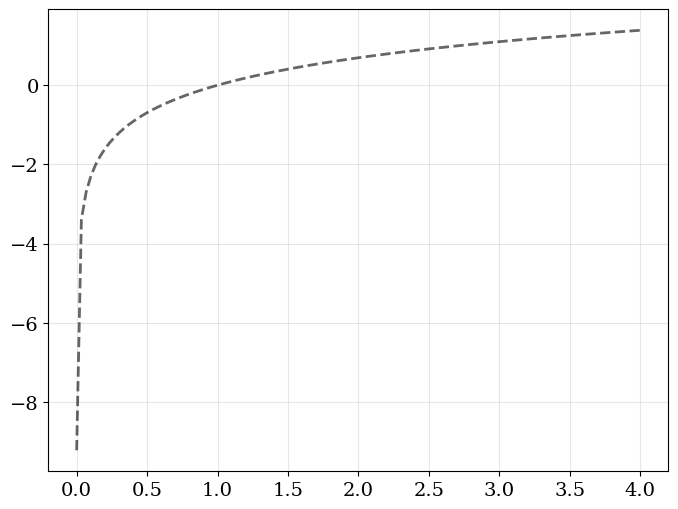

In [40]:
v = np.log(grid)
n = 30

fig, ax = plt.subplots()
ax.plot(grid, v, color='k', linestyle="dashed", lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v_greedy, v = T(v, og)  # Apply the Bellman operator
    ax.plot(grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set(ylim=(-10, 10), xlim=(np.min(grid), np.max(grid)))
plt.show()

In [20]:
def solve_model(og, tol=1e-3, max_iter=1000, verbose=True, print_skip=25):
    """
    Solve model by iterating with the Bellman operator.
    """
    # Set up loop
    v = og.u(og.grid)  # Initial condition
    i = 0
    delta = tol + 1

    while i < max_iter and delta > tol:
        v_greedy, v_new = T(v, og)
        delta = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Delta at iteration {i} is {delta}.")
        v = v_new

    if delta > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new

In [21]:
v_greedy, v_solution = solve_model(og)

Delta at iteration 25 is 4.231336509152108.
Delta at iteration 50 is 116.17250972648299.
Delta at iteration 75 is 2213.1968845005867.


KeyboardInterrupt: 

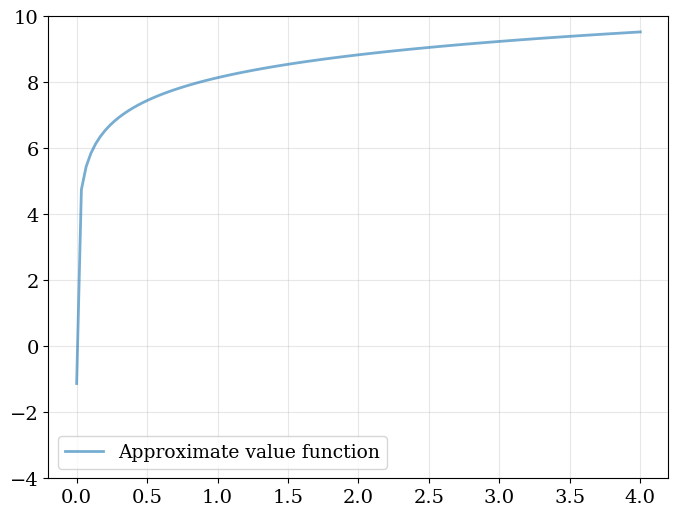

In [58]:
fig, ax = plt.subplots()
ax.plot(grid, v_solution, lw=2, alpha=0.6, label='Approximate value function')
ax.legend()
ax.set_ylim(-4, 10)
plt.show()

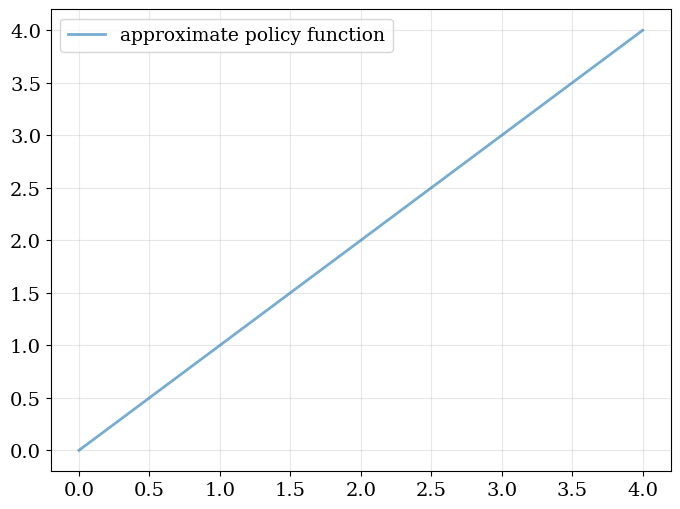

In [60]:
fig, ax = plt.subplots()
ax.plot(grid, v_greedy, lw=2, alpha=0.6, label='approximate policy function')
ax.legend()
plt.show()